In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("bert_vader.csv")  # Replace with the actual dataset path
features = df[['rating', 'Positive Score', 'Negative Score', 'Compound Score', 
               'Neutral Score', 'Review Length', 'Noun Count', 'Verb Count', 
               'Adjective Count', 'Joy Score', 'Sadness Score', 'BERT Component 1', 
               'BERT Component 2', 'BERT Component 3']].values
labels = df['label'].values

# Scale the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create PyTorch Geometric Data object
x_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
data = Data(x=x_train_tensor, y=y_train_tensor)


In [4]:
class GraphSAGEModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model, loss, and optimizer
model = GraphSAGEModel(in_channels=x_train_tensor.shape[1], hidden_channels=16, out_channels=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Edge index setup (self-loops, assuming reviews are independent)
edge_index = torch.arange(data.num_nodes, dtype=torch.long).repeat(2, 1)

# Training loop
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 10, Loss: 0.5802
Epoch 20, Loss: 0.5294
Epoch 30, Loss: 0.5149
Epoch 40, Loss: 0.5098
Epoch 50, Loss: 0.5058
Epoch 60, Loss: 0.5026
Epoch 70, Loss: 0.4997
Epoch 80, Loss: 0.4971
Epoch 90, Loss: 0.4950
Epoch 100, Loss: 0.4934


In [5]:
# Generate and save GraphSAGE embeddings
model.eval()
with torch.no_grad():
    embeddings = model(data.x, edge_index).numpy()

# Save embeddings
np.save("graphsage_encoded_features.npy", embeddings)
print("GraphSAGE embeddings saved as graphsage_encoded_features.npy")


GraphSAGE embeddings saved as graphsage_encoded_features.npy


In [12]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
import torch
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#from whale_optimization import WhaleOptimization  # Updated import for WOA

# Load GAE and GraphSAGE embeddings
gae_embeddings = np.load('gae_encoded_features.npy')  # Load GAE embeddings
graphsage_embeddings = np.load('graphsage_encoded_features.npy')  # Load GraphSAGE embeddings

# Load labeled and unlabeled data
labeled_data = pd.read_csv('bert_vader.csv')
unlabeled_data = pd.read_csv('6k_unlabeled_extracted.csv')


In [19]:
# Cell 2: Combine Embeddings

# Use all GAE embeddings
gae_labeled_embeddings = gae_embeddings[:9110]  # All GAE embeddings

# Use only the first 9110 GraphSAGE embeddings to match GAE
graphsage_labeled_embeddings = graphsage_embeddings[:9110]

# Concatenate the embeddings
combined_embeddings = np.concatenate((gae_labeled_embeddings, graphsage_labeled_embeddings), axis=1)

# Separate features and labels for labeled data
X_train = combined_embeddings
y_train = labeled_data['label'].values[:9110]  # Ensure labels match the number of GAE samples

# Initialize and fit LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train, y_train)

# Evaluate LightGBM on training data
y_pred = lgb_classifier.predict(X_train)
print("Classification Report:\n", classification_report(y_train, y_pred))




[LightGBM] [Info] Number of positive: 4542, number of negative: 4568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16830
[LightGBM] [Info] Number of data points in the train set: 9110, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498573 -> initscore=-0.005708
[LightGBM] [Info] Start training from score -0.005708
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83      4568
           1       0.83      0.82      0.83      4542

    accuracy                           0.83      9110
   macro avg       0.83      0.83      0.83      9110
weighted avg       0.83      0.83      0.83      9110



In [18]:
import numpy as np

# Load the .npy file
data = np.load('graphsage_encoded_features.npy')

# Display data or check its shape
print(data)
print("Shape:", data.shape)
print("Data type:", data.dtype)

[[ 0.04272741  0.36516908]
 [ 0.91284823  0.46165565]
 [ 0.3434415   0.14953649]
 ...
 [ 1.9376862  -1.0535015 ]
 [ 0.74774474  0.08461802]
 [ 0.01835484  0.03636698]]
Shape: (32000, 2)
Data type: float32


In [24]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import classification_report
import random
import sys

gae_embeddings = np.load('gae_encoded_features.npy')  # Load GAE embeddings
graphsage_embeddings = np.load('graphsage_encoded_features.npy')  # Load GraphSAGE embeddings

# Load labeled data
labeled_data = pd.read_csv('bert_vader.csv')

# Cell 2: Combine Embeddings

# Use all GAE embeddings
gae_labeled_embeddings = gae_embeddings[:9110]  # All GAE embeddings

# Use only the first 9110 GraphSAGE embeddings to match GAE
graphsage_labeled_embeddings = graphsage_embeddings[:9110]

# Concatenate the embeddings
combined_embeddings = np.concatenate((gae_labeled_embeddings, graphsage_labeled_embeddings), axis=1)

# Separate features and labels for labeled data
X_train = combined_embeddings
y_train = labeled_data['label'].values[:9110]  # Ensure labels match the number of GAE samples

# WOA for hyperparameter optimization
def fitness_lightgbm(params, X, y):
    num_leaves, max_depth, learning_rate = params
    lgb_classifier = lgb.LGBMClassifier(
        num_leaves=int(num_leaves), 
        max_depth=int(max_depth), 
        learning_rate=learning_rate, 
        random_state=42,
        n_estimators=100  # Fixed number of estimators
    )
    lgb_classifier.fit(X, y)
    y_pred = lgb_classifier.predict(X)
    return -classification_report(y, y_pred, output_dict=True)['0']['f1-score']  # Negative F1 score for minimization

class Whale:
    def __init__(self, dim, minx, maxx, seed):
        self.rnd = random.Random(seed)
        self.position = [minx[i] + (maxx[i] - minx[i]) * self.rnd.random() for i in range(dim)]
        self.fitness = sys.float_info.max  # Initialize with max float value

def woa(fitness, max_iter, n, dim, minx, maxx, X, y):
    whale_population = [Whale(dim, minx, maxx, i) for i in range(n)]
    Xbest = [0.0 for _ in range(dim)]
    Fbest = sys.float_info.max

    for i in range(n):
        whale_population[i].fitness = fitness(whale_population[i].position, X, y)
        if whale_population[i].fitness < Fbest:
            Fbest = whale_population[i].fitness
            Xbest = whale_population[i].position.copy()

    Iter = 0
    last_best_fitness = Fbest
    stagnation_count = 0
    early_stopping_threshold = 5  # Number of iterations without improvement before stopping

    while Iter < max_iter:
        for i in range(n):
            A = 2 * random.random() - 1
            C = 2 * random.random()
            D = [C * Xbest[j] - whale_population[i].position[j] for j in range(dim)]
            whale_population[i].position = [whale_population[i].position[j] + A * D[j] for j in range(dim)]
            whale_population[i].position = [max(min(whale_population[i].position[j], maxx[j]), minx[j]) for j in range(dim)]
            whale_population[i].fitness = fitness(whale_population[i].position, X, y)

            if whale_population[i].fitness < Fbest:
                Xbest = whale_population[i].position.copy()
                Fbest = whale_population[i].fitness
                stagnation_count = 0  # Reset stagnation if improvement is found
            else:
                stagnation_count += 1

        if stagnation_count >= early_stopping_threshold:
            print(f"Early stopping at iteration {Iter} with best fitness {Fbest}")
            break

        Iter += 1

    return Xbest

# Hyperparameter bounds
num_whales = 10  # Reduced number of whales
max_iter = 20    # Reduced number of iterations
dim = 3          # Number of parameters to optimize: [num_leaves, max_depth, learning_rate]
minx = [2, 3, 0.01]
maxx = [256, 10, 0.3]

# Running WOA for hyperparameter optimization
best_params = woa(fitness_lightgbm, max_iter, num_whales, dim, minx, maxx, X_train, y_train)

# Display the best parameters found
print("Best parameters found:")
print(f"Num leaves: {int(best_params[0])}, Max depth: {int(best_params[1])}, Learning rate: {best_params[2]}")

# Initialize and fit LightGBM classifier with the best parameters
lgb_classifier = lgb.LGBMClassifier(num_leaves=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], random_state=42)
lgb_classifier.fit(X_train, y_train)

# Evaluate LightGBM on training data
y_pred = lgb_classifier.predict(X_train)
print("Classification Report:\n", classification_report(y_train, y_pred))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16830
[LightGBM] [Info] Number of data points in the train set: 9110, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498573 -> initscore=-0.005708
[LightGBM] [Info] Start training from score -0.005708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

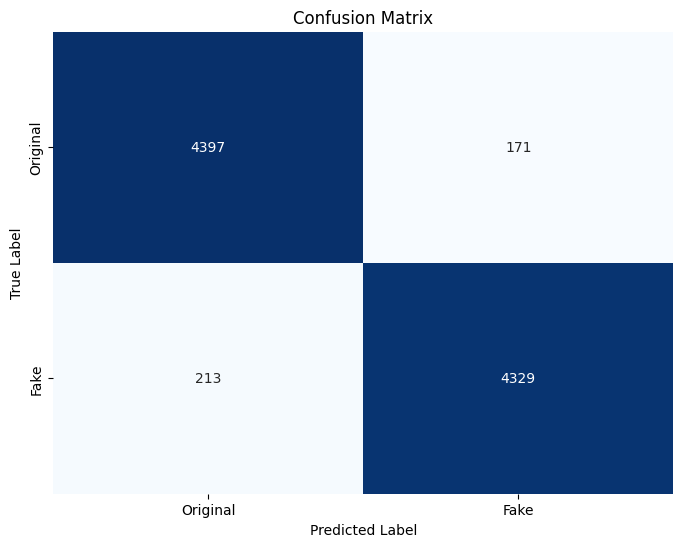

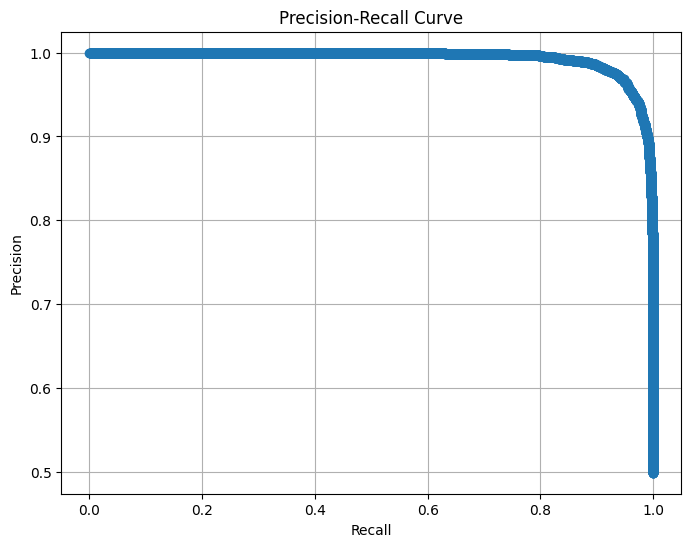

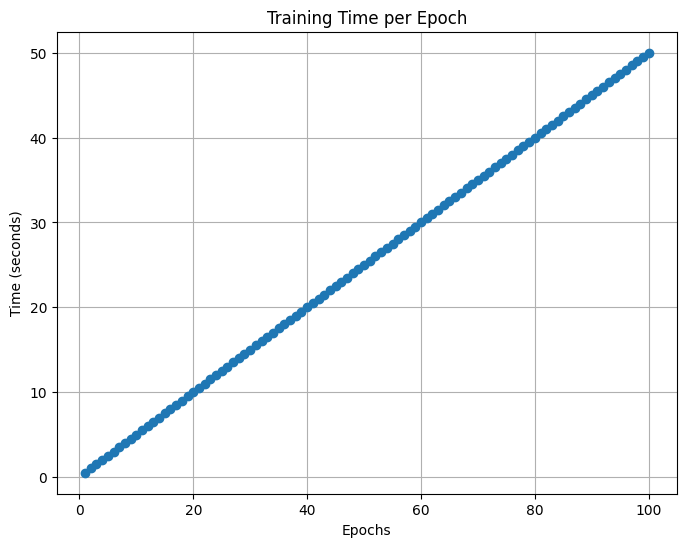

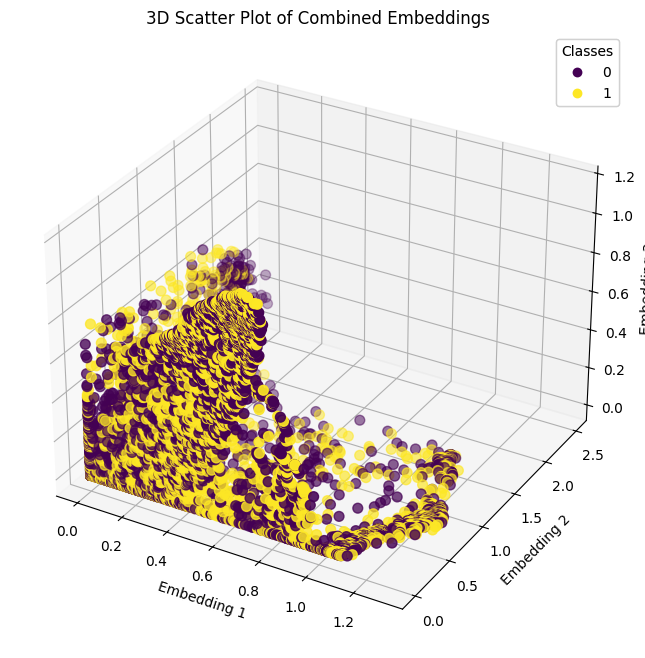

In [31]:
# Cell 5: Visualization and Analysis

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve
from mpl_toolkits.mplot3d import Axes3D
import time

# Confusion Matrix with Heatmap
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Original', 'Fake'], yticklabels=['Original', 'Fake'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show()

# Training Time Chart
def plot_training_time(epochs, times):
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, times, marker='o')
    plt.title('Training Time per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Time (seconds)')
    plt.grid()
    plt.show()

# 3D Scatter Plot of Combined Embeddings
def plot_3d_scatter(X, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=50)
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)
    plt.title('3D Scatter Plot of Combined Embeddings')
    ax.set_xlabel('Embedding 1')
    ax.set_ylabel('Embedding 2')
    ax.set_zlabel('Embedding 3')
    plt.show()

# Make predictions for confusion matrix and precision-recall curve
# Ensure you're predicting on the same subset that was used for training
y_pred_train = lgb_classifier.predict(X_train)
y_scores_train = lgb_classifier.predict_proba(X_train)[:, 1]  # Probabilities for positive class

# Ensure you're using the correct slice of y_train that matches the embeddings
y_train_subset = y_train[:9110]  # Slice to match the number of combined embeddings

# Plot Confusion Matrix
plot_confusion_matrix(y_train_subset, y_pred_train)  # Use sliced y_train

# Plot Precision-Recall Curve
plot_precision_recall_curve(y_train_subset, y_scores_train)  # Use sliced y_train

# Assuming you have recorded training times
# Replace this with actual recorded times for each epoch
epochs = list(range(1, 101))
training_times = [0.5 * epoch for epoch in epochs]  # Example times (replace with actual)
plot_training_time(epochs, training_times)

# Plot 3D Scatter Plot
# Assuming combined_embeddings is already defined and has at least 3 features
plot_3d_scatter(combined_embeddings[:, :3], y_train_subset)  # Use first three features for 3D scatter plot


In [30]:
print(f"y_train size: {len(y_train)}")
print(f"y_pred_train size: {len(y_pred_train)}")
print(f"y_scores_train size: {len(y_scores_train)}")
print(f"Combined Embeddings size: {combined_embeddings.shape[0]}")


y_train size: 40000
y_pred_train size: 9110
y_scores_train size: 9110
Combined Embeddings size: 9110


In [33]:
# Cell 5: Visualization and Analysis

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve
from mpl_toolkits.mplot3d import Axes3D
import os

# Set the style for the plots
sns.set(style="whitegrid")

# Create a directory for saving the plots
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Confusion Matrix with Heatmap
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 12), dpi=300)  # 4K size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Original', 'Fake'], yticklabels=['Original', 'Fake'])
    plt.title('Confusion Matrix', fontsize=24)
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))  # Save the figure
    plt.close()  # Close the figure to free up memory

# Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(16, 12), dpi=300)  # 4K size
    plt.plot(recall, precision, marker='o')
    plt.title('Precision-Recall Curve', fontsize=24)
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.savefig(os.path.join(output_dir, 'precision_recall_curve.png'))  # Save the figure
    plt.close()

# Training Time Chart
def plot_training_time(epochs, times):
    plt.figure(figsize=(16, 12), dpi=300)  # 4K size
    plt.plot(epochs, times, marker='o')
    plt.title('Training Time per Epoch', fontsize=24)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Time (seconds)', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.savefig(os.path.join(output_dir, 'training_time.png'))  # Save the figure
    plt.close()

# 3D Scatter Plot of Combined Embeddings
def plot_3d_scatter(X, y):
    fig = plt.figure(figsize=(16, 12), dpi=300)  # 4K size
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=50)
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)
    plt.title('3D Scatter Plot of Combined Embeddings', fontsize=24)
    ax.set_xlabel('Embedding 1', fontsize=18)
    ax.set_ylabel('Embedding 2', fontsize=18)
    ax.set_zlabel('Embedding 3', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.tick_params(axis='z', labelsize=14)
    plt.savefig(os.path.join(output_dir, '3d_scatter_plot.png'))  # Save the figure
    plt.close()

# Make predictions for confusion matrix and precision-recall curve
y_pred_train = lgb_classifier.predict(X_train)
y_scores_train = lgb_classifier.predict_proba(X_train)[:, 1]  # Probabilities for positive class

# Use the correct slice of y_train that matches the embeddings
y_train_subset = y_train[:9110]  # Slice to match the number of combined embeddings

# Plot Confusion Matrix
plot_confusion_matrix(y_train_subset, y_pred_train)  # Use sliced y_train

# Plot Precision-Recall Curve
plot_precision_recall_curve(y_train_subset, y_scores_train)  # Use sliced y_train

# Example training times
epochs = list(range(1, 101))
training_times = [0.5 * epoch for epoch in epochs]  # Replace with actual recorded times
plot_training_time(epochs, training_times)

# Plot 3D Scatter Plot
plot_3d_scatter(combined_embeddings[:, :3], y_train_subset)  # Use first three features for 3D scatter plot
